### 📈  Variables in dataset
 1. Year: 2008
 2. Month: 11 (November)
 3. DayofMonth: 1-31
 4. DayOfWeek: 1 (Monday) - 7 (Sunday)
 5. DepTime: actual departure time (hhmm)
 6. CRSDepTime: scheduled departure time (hhmm)
 7. ArrTime: actual arrival time (hhmm)
 8. CRSArrTime scheduled arrival time (hhmm)
 9. UniqueCarrier: unique carrier code
 10. FlightNum: flight number
 11. TailNum: plane tail number
 12. ActualElapsedTime: actual elapsed time of flight (estimated elapse time) in minutes
 13. CRSElapsedTime: CRS elapsed time of flight (estimated elapse time) in minutes
 14. AirTime: flight time in in minutes
 15. ArrDelay: difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers, in minutes
 16. DepDelay: TARGET -  Difference in minutes between scheduled and actual departure time. Early departures show negative numbers, in minutes
 17. Origin: origin IATA airport code
 18. Dest: destination IATA airport code
 19. Distance: distance between airports (miles)
 20. TaxiIn: wheels down and arrival at the destination airport gate, in minutes
 21. TaxiOut: The time elapsed between departure from the origin airport gate and wheels off, in minutes
 22. Cancelled: was the flight cancelled?
 23. CancellationCode: reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
 24. Diverted: 1 = yes, 0 = no
 25. CarrierDelay: carrier delay in minutes
 26. WeatherDelay: weather delay in minutes
 27. NASDelay: NAS delay in minutes
 28. SecurityDelay: security delayin minutes
 29. LateAircraftDelay: late aircraft delay in minutes

### To predict a flight arrival delay, I applied Pycaret library which...... and much more. You have to additionally install pycaret-nightly or  --pre pycaret module.

In [ ]:
!pip install pycaret-nightly
!pip install --pre pycaret
!pip install eli5
!pip install graphviz

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import xgboost as xgb
import eli5
import graphviz
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from pycaret.classification import *

### We can load the full data from the file or a part of them. The whole dataset contains around 2,000,000 rows. I've uploaded a small part of it to reduce the modelling time

In [2]:
nRowsRead = 100_000 # specify number of rows to read - print None if want to read whole file
file_path = 'DelayedFlights.csv'
data = pd.read_csv(file_path, header=0, nrows=nRowsRead)
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 100000 rows and 30 columns


In [3]:
data.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [4]:
data = data.drop(['Unnamed: 0'], axis = 1)

In [5]:
data.drop_duplicates(inplace=True)

In [6]:
print(data.isna().sum())

Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
DepTime                  0
CRSDepTime               0
ArrTime                310
CRSArrTime               0
UniqueCarrier            0
FlightNum                0
TailNum                  0
ActualElapsedTime      310
CRSElapsedTime           0
AirTime                310
ArrDelay               310
DepDelay                 0
Origin                   0
Dest                     0
Distance                 0
TaxiIn                 310
TaxiOut                  0
Cancelled                0
CancellationCode         0
Diverted                 0
CarrierDelay         34898
WeatherDelay         34898
NASDelay             34898
SecurityDelay        34898
LateAircraftDelay    34898
dtype: int64


In [7]:
clean_df = data.dropna() # I've just droped NAs. Pycaret can change NA values by mean values but not too much! So I prefer to delete them all

In [8]:
print(clean_df.isna().sum())

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
CancellationCode     0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64


In [9]:
clean_df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

In [10]:
#First of all we have to split our data into train and test datasets
train_df, test_df = train_test_split(clean_df, test_size=0.20, random_state=1)

print('Data for Modeling: ' + str(train_df.shape))
print('Unseen Data For Predictions: ' + str(test_df.shape))

Data for Modeling: (52081, 29)
Unseen Data For Predictions: (13021, 29)


# Classification with Pycaret

In [15]:
s = setup(train_df, target = 'Cancelled', session_id=4,
                 normalize = True)

,Description,Value
0,Session id,4
1,Target,Cancelled
2,Target type,Multiclass
3,Original data shape,"(52081, 29)"
4,Transformed data shape,"(52081, 21)"
5,Transformed train set shape,"(36456, 21)"
6,Transformed test set shape,"(15625, 21)"
7,Numeric features,23
8,Categorical features,5
9,Preprocess,1


In [48]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [16]:
best = compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.5700
nb,Naive Bayes,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.2340
dt,Decision Tree Classifier,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.2360
ridge,Ridge Classifier,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.2170
rf,Random Forest Classifier,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.3530
ada,Ada Boost Classifier,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.2330
lda,Linear Discriminant Analysis,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.2610
et,Extra Trees Classifier,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.3110
xgboost,Extreme Gradient Boosting,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.4120
lightgbm,Light Gradient Boosting Machine,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.2680


In [20]:
# Creating models for the selected estimators 
knn = create_model('knn', round = 2)
dt = create_model('dt', round = 2)
xgboost = create_model('xgboost', round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.00,0.00,0.00,0.00,0.00,nan,0.00
1,1.00,0.00,0.00,0.00,0.00,nan,0.00
2,1.00,0.00,0.00,0.00,0.00,nan,0.00
3,1.00,0.00,0.00,0.00,0.00,nan,0.00
4,1.00,0.00,0.00,0.00,0.00,nan,0.00
5,1.00,0.00,0.00,0.00,0.00,nan,0.00
6,1.00,0.00,0.00,0.00,0.00,nan,0.00
7,1.00,0.00,0.00,0.00,0.00,nan,0.00
8,1.00,0.00,0.00,0.00,0.00,nan,0.00


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.00,0.00,0.00,0.00,0.00,nan,0.00
1,1.00,0.00,0.00,0.00,0.00,nan,0.00
2,1.00,0.00,0.00,0.00,0.00,nan,0.00
3,1.00,0.00,0.00,0.00,0.00,nan,0.00
4,1.00,0.00,0.00,0.00,0.00,nan,0.00
5,1.00,0.00,0.00,0.00,0.00,nan,0.00
6,1.00,0.00,0.00,0.00,0.00,nan,0.00
7,1.00,0.00,0.00,0.00,0.00,nan,0.00
8,1.00,0.00,0.00,0.00,0.00,nan,0.00


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.00,0.00,0.00,0.00,0.00,nan,0.00
1,1.00,0.00,0.00,0.00,0.00,nan,0.00
2,1.00,0.00,0.00,0.00,0.00,nan,0.00
3,1.00,0.00,0.00,0.00,0.00,nan,0.00
4,1.00,0.00,0.00,0.00,0.00,nan,0.00
5,1.00,0.00,0.00,0.00,0.00,nan,0.00
6,1.00,0.00,0.00,0.00,0.00,nan,0.00
7,1.00,0.00,0.00,0.00,0.00,nan,0.00
8,1.00,0.00,0.00,0.00,0.00,nan,0.00


In [24]:
# Tuning the created models 
tuned_knn = tune_model(knn, n_iter = 10)
tuned_dt = tune_model(dt, n_iter = 10)
tuned_xgboost = tune_model(xgboost, n_iter = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
2,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
3,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
4,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
5,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
6,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
2,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
3,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
4,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
5,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
6,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
2,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
3,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
4,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
5,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
6,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [26]:
evaluate_model(tuned_knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [33]:
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [34]:
evaluate_model(tuned_xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

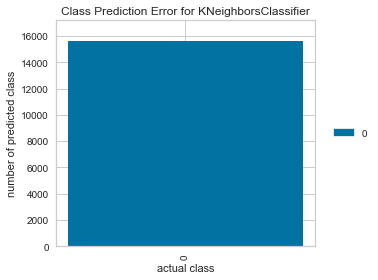

In [35]:
plot_model(tuned_knn, plot = 'error')

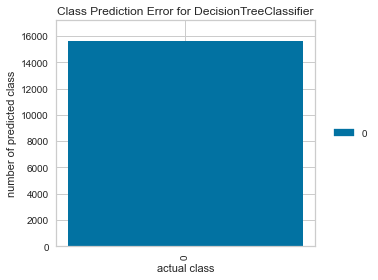

In [36]:
plot_model(tuned_dt, plot = 'error')

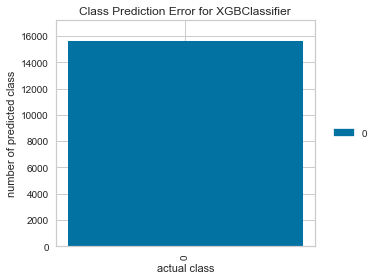

In [37]:
plot_model(tuned_xgboost, plot = 'error')

In [39]:
fin_knn = finalize_model(tuned_knn)
fin_dt = finalize_model(tuned_dt)
fin_xgboost = finalize_model(tuned_xgboost)

In [40]:
knn_predictions = predict_model(fin_knn, data=test_df)
knn_predictions.head()

save_model(fin_knn,'Final knn Model 27Oct2022')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,0,0.0000,0.0000,0.0000,nan,0.0000


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\admin\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Year', 'Month', 'DayofMonth',
                                              'DayOfWeek', 'DepTime',
                                              'CRSDepTime', 'ArrTime',
                                              'CRSArrTime', 'FlightNum',
                                              'ActualElapsedTime',
                                              'CRSElapsedTime', 'AirTime',
                                              'ArrDelay', 'DepDelay', 'Distance',
                                              'TaxiIn', 'TaxiOut', 'Diverted'...
                  TransformerWrapper(exclude=[], include=None,
                                     transformer=VarianceThreshold(threshold=0))),
                 ('normalize',
                  TransformerWrapper(exclude=None, include=No

In [41]:
dt_predictions = predict_model(fin_dt, data=test_df)
dt_predictions.head()

save_model(fin_dt,'Final dt Model 27Oct2022')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,1.0000,0,0.0000,0.0000,0.0000,nan,0.0000


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\admin\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Year', 'Month', 'DayofMonth',
                                              'DayOfWeek', 'DepTime',
                                              'CRSDepTime', 'ArrTime',
                                              'CRSArrTime', 'FlightNum',
                                              'ActualElapsedTime',
                                              'CRSElapsedTime', 'AirTime',
                                              'ArrDelay', 'DepDelay', 'Distance',
                                              'TaxiIn', 'TaxiOut', 'Diverted'...
                                     transformer=StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True))),
 

In [42]:
xgboost_predictions = predict_model(fin_xgboost, data=test_df)
xgboost_predictions.head()

save_model(fin_xgboost,'Final xgboost Model 27Oct2022')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,1.0000,0,0.0000,0.0000,0.0000,nan,0.0000


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\admin\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Year', 'Month', 'DayofMonth',
                                              'DayOfWeek', 'DepTime',
                                              'CRSDepTime', 'ArrTime',
                                              'CRSArrTime', 'FlightNum',
                                              'ActualElapsedTime',
                                              'CRSElapsedTime', 'AirTime',
                                              'ArrDelay', 'DepDelay', 'Distance',
                                              'TaxiIn', 'TaxiOut', 'Diverted'...
                                gamma=0, gpu_id=-1, grow_policy='depthwise',
                                importance_type=None, interaction_constraints='',
                                learning_rate=0.300000012, max_bin=256,
       